### do gen-matching with delphes root files

In [1]:
#env : Lpr
# used to compare the gen-top in CMS official ttbar samples and Delphes samples

In [1]:
import uproot
import awkward as ak
from glob import glob
from coffea.nanoevents import NanoEventsFactory, DelphesSchema
import pickle, json, gzip
import numpy as np
from typing import Optional, List, Dict, Tuple
from copy import copy
from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler
from tqdm import tqdm
import pathlib
import os
import boost_histogram as bh

In [2]:
plot_dir = "../plots/gen_matching/23Jul2024"
_ = os.system(f"mkdir -p {plot_dir}")

In [31]:
delphes_roots = {
    'cms_official' : "/data/bond/zhaoyz/Pheno/ttbar_Wcb/gen_top_val/cms_official/out_1.root",
    'delphes'      : "/data/bond/zhaoyz/Pheno/ttbar_Wcb/gen_top_val/TTbar_semilep/events_delphes_199.root",
}    
files = {typefile : {} for typefile in delphes_roots}
for typefile in delphes_roots:
    files[typefile] = NanoEventsFactory.from_root(
        delphes_roots[typefile],
        treepath='/Delphes',
        schemaclass=DelphesSchema,
    ).events()

In [4]:
# use leading pT jet first, anyway we will only select one AK8 jet in the end
def pad_val(
    arr: ak.Array,
    target: int,
    value: float,
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    return ret.to_numpy() if to_numpy else ret

import math
def delta_r(a, b):
    deta = a.Eta - b.Eta
    dphi = (a.Phi - b.Phi + math.pi) % (2 * math.pi) - math.pi
    return np.hypot(deta, dphi)

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.ROOT)

def flow(hist: bh.Histogram, overflow: bool=False, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])

skim_vars = {
    "eta": "Eta",
    "phi": "Phi",
    "mass": "Mass",
    "pt": "Pt",
}

### Investigate jet information

In [6]:
events = files["TTbar_semilep"]


### let's see the gen-top pt distribution

### jet matching

In [5]:
d_PDGID = 1
u_PDGID = 2
s_PDGID = 3
b_PDGID = 5
c_PDGID = 4
TOP_PDGID = 6

g_PDGID = 21

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

Z_PDGID = 23
W_PDGID = 24
H_PDGID = 25

#define deltaR
deltaR = 0.8

In [6]:
# finding the two gen tops
events = files["cms_official"]
tops = events.Particle[
    (abs(events.Particle.PID) == TOP_PDGID) * (events.Particle.Status == 62)
]

In [7]:
tops.PID

<Array [[6, -6], [6, -6], ... [6, -6], [6, -6]] type='38000 * var * int32[parame...'>

In [18]:
# collect all bs
bs = events.Particle[tops.D2]

In [9]:
# find the last W index

def find_last_position(arr, value):
    mask = (arr == value)
    reversed_mask = mask[:, ::-1]
    reversed_positions = ak.argmax(reversed_mask, axis=1)
    lengths = ak.num(arr, axis=1)
    positions = lengths - 1 - reversed_positions
    return positions



In [10]:
pos_w_plus = find_last_position(events.Particle.PID, 24)
pos_w_plus

<Array [15, 29, 30, 16, 38, ... 50, 18, 42, 37] type='38000 * ?int64'>

In [11]:
pos_w_minus = find_last_position(events.Particle.PID, -24)
pos_w_minus

<Array [20, 34, 35, 22, 40, ... 57, 23, 47, 41] type='38000 * ?int64'>

In [12]:
#last copy W position
w_index_array = ak.Array(ak.Array([pos_w_plus, pos_w_minus]).to_numpy().T)

In [13]:
# collect last copy W
ws = events.Particle[ak.Array([range(len(events.Particle))]).to_numpy().T, w_index_array.to_numpy()]

In [14]:
# define hadronic decay W
had_w_sel = (abs(events.Particle[ak.Array([range(len(events.Particle))]).to_numpy().T, ws.D1.to_numpy()].PID) <= 5)

In [15]:
# collect all hadronic decay W in all events
had_ws = ws[had_w_sel]

In [16]:
had_ws.PID

<Array [-24, -24, -24, 24, ... 24, -24, -24] type='38000 * int32[parameters={"__...'>

In [36]:
# collect hadronic decay top(same sign with hadronic W):
tops_had = ak.flatten(ak.pad_none(tops[had_ws.Charge == abs(tops.PID)/tops.PID], 1, axis = 1, clip = True), axis = 1)

In [37]:
tops_had.PID

<Array [-6, -6, -6, 6, 6, ... -6, 6, 6, -6, -6] type='38000 * ?int32[parameters=...'>

In [25]:
tops_had.PT

<Array [19.6, 76.2, 59.5, ... 92.9, 62.4, 30.2] type='38000 * ?float32[parameter...'>

In [38]:
def get_top_pt(events):
    tops = events.Particle[(abs(events.Particle.PID) == TOP_PDGID) * (events.Particle.Status == 62)]
    pos_w_plus = find_last_position(events.Particle.PID, 24)
    pos_w_minus = find_last_position(events.Particle.PID, -24)
    w_index_array = ak.Array(ak.Array([pos_w_plus, pos_w_minus]).to_numpy().T)
    ws = events.Particle[ak.Array([range(len(events.Particle))]).to_numpy().T, w_index_array.to_numpy()]
    had_w_sel = (abs(events.Particle[ak.Array([range(len(events.Particle))]).to_numpy().T, ws.D1.to_numpy()].PID) <= 5)
    had_ws = ws[had_w_sel]
    tops_had = ak.flatten(ak.pad_none(tops[had_ws.Charge == abs(tops.PID)/tops.PID], 1, axis = 1, clip = True), axis = 1)
    return tops_had.PT

In [39]:
get_top_pt(files["cms_official"])

<Array [45.4, 72.6, 36.8, ... 118, 52.1, 172] type='38000 * ?float32[parameters=...'>

In [41]:
get_top_pt(files["delphes"])

<Array [110, 161, 212, ... 88.7, 280, 39.5] type='5076 * ?float32[parameters={"_...'>

In [61]:
def plot_top_pt(files, nbins=50, x_min=0, x_max=600, legend_location='upper left',suffix = "", cms_official = "cms_official", delphes = "delphes"):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    cms_official_top_pt = get_top_pt(files[cms_official])
    delphes_top_pt = get_top_pt(files[delphes])
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    f = plt.figure(figsize=(14, 15))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    # hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    
    # histogram of cms
    hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
    hist_region.fill(cms_official_top_pt)
    hist_value_up = flow(hist_region)[0]
    denom_up = np.sum(hist_value_up)
    hist_var_up   = flow(hist_region)[1]
    
    #histogram of delphes
    hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
    hist_region.fill(delphes_top_pt)
    hist_value_nom = flow(hist_region)[0]
    denom_nom = np.sum(hist_value_nom)
    hist_var_nom   = flow(hist_region)[1]
    
    #error of cms
    err_up = np.nan_to_num(error_bar(hist_value_up/denom_up, hist_var_up/(denom_up**2), type = "mc"), nan = 0)
    hep.histplot(hist_value_up/denom_up, bins=hist_region.axes[0].edges, yerr=err_up, label="CMS official ttbar samples", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")

    #error of delphes
    err_nom = np.nan_to_num(error_bar(hist_value_nom/denom_nom, hist_var_nom/(denom_nom**2), type = "mc"), nan = 0)
    hep.histplot(hist_value_nom/denom_nom, bins=hist_region.axes[0].edges, yerr=err_nom, label="Delphes ttbar samples", histtype='step', stack=False, linewidth=2, ax=ax,color = "red")

    #error of ratio
    err_up_nom_ratio   = np.sqrt(np.power(err_up/(hist_value_up/denom_up),2) + np.power(err_nom/(hist_value_nom/denom_nom),2))
    hep.histplot((hist_value_up/denom_up)/(hist_value_nom/denom_nom),   bins=hist_region.axes[0].edges, yerr=err_up_nom_ratio, color='black',  label="JER,up/center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2)
 
    ax1.set_xlabel("gen-level hadronic top pT(GeV)")
    ax.set_ylabel("Events")
    ax1.set_ylabel("ratio")
    ax1.set_ylim(0, 2)
    # ax.set_yscale('log') 
    
    ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
    ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
    # plt.text(0.05,0.83,region+ ", "+ files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
    plt.savefig(f"{plot_dir}/pt_{suffix}.pdf", bbox_inches='tight')    

/tmp/ipykernel_3813728/3272209719.py:50: RuntimeWarning: invalid value encountered in true_divide
  number = h**2 / var
/tmp/ipykernel_3813728/3272209719.py:67: RuntimeWarning: invalid value encountered in true_divide
  up_error_bar *= var/h
/tmp/ipykernel_3813728/3272209719.py:68: RuntimeWarning: invalid value encountered in true_divide
  down_error_bar *= var/h
/tmp/ipykernel_3813728/4141422011.py:38: RuntimeWarning: invalid value encountered in true_divide
  err_up_nom_ratio   = np.sqrt(np.power(err_up/(hist_value_up/denom_up),2) + np.power(err_nom/(hist_value_nom/denom_nom),2))
/tmp/ipykernel_3813728/4141422011.py:39: RuntimeWarning: divide by zero encountered in true_divide
  hep.histplot((hist_value_up/denom_up)/(hist_value_nom/denom_nom),   bins=hist_region.axes[0].edges, yerr=err_up_nom_ratio, color='black',  label="JER,up/center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2)


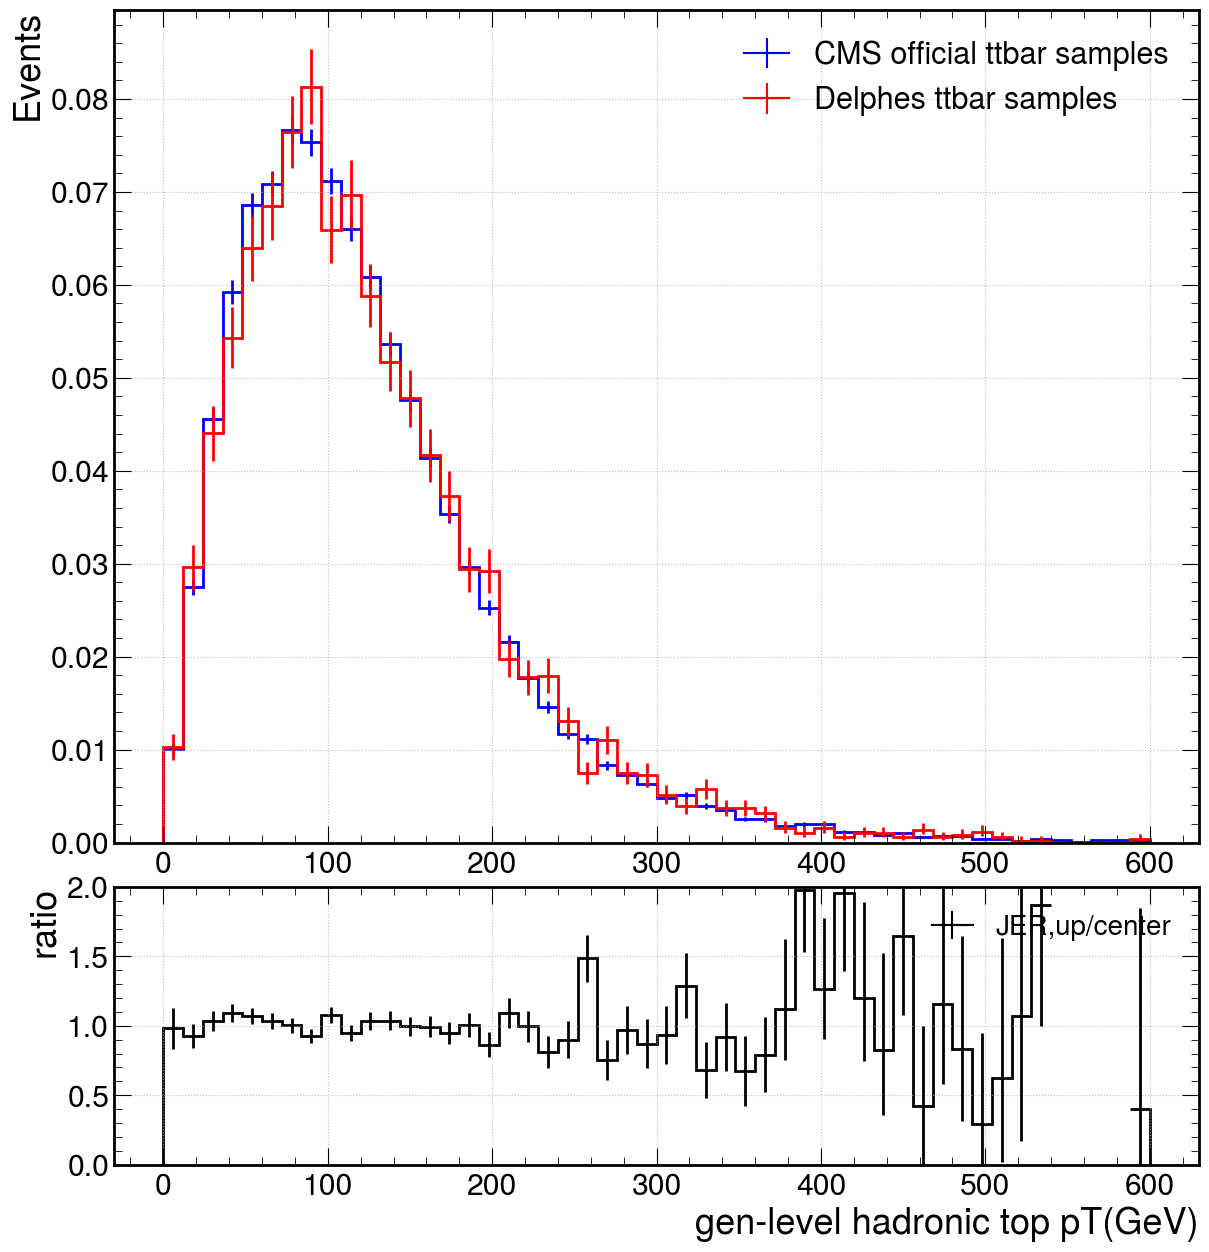

In [62]:
plot_top_pt(files)